# dcd transplantation

In [ ]:
import datetime
import pandas as pd
import numpy as np
import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

import joblib
import pickle
import optuna
import optuna.integration.lightgbm as lgb

from lifelines import KaplanMeierFitter


In [ ]:
unet = pd.read_excel('##########################################')

In [ ]:
df_60_80 = pd.read_excel('##########################################')
df_60_80_list = df_60_80['UNET_ID'].unique()

C_60_60_time = []
C_80_80_time = []
for i in range(len(unet)):
    a = unet.iat[i, unet.columns.get_loc('UNET_ID')]
    b = unet.iat[i, unet.columns.get_loc('Deth_time')]
    if a not in df_60_80_list:
        if b == '60~' or b =='~':
            y1 = 3
            y2 = 3
        else:
            b = float(b)
            if b >= 60:
                y1=3
                y2=3
            elif b <60 and b >=45:
                y1=2
                y2=2
            elif b <45 and b >=30:
                y1=1
                y2=1
            elif b <30:
                y1=0
                y2=0
            else:
                y1=np.NAN
                y2=np.NAN

    elif a in df_60_80_list:
        c = float(df_60_80[df_60_80['UNET_ID'] == a]['from 60/60 to death pronounce'].tolist()[0])
        d = float(df_60_80[df_60_80['UNET_ID'] == a]['from 80/80 to death pronounce'].tolist()[0])
        if c >= 60:
            y1 = 3
        elif c < 60 and c >= 45:
            y1 =2
        elif c < 45 and c >= 30:
            y1 =1
        elif c < 30:
            y1 =0
        else:
            y1 = np.NAN
        if d >= 60:
            y2 = 3
        elif c < 60 and c >= 45:
            y2 =2
        elif c < 45 and c >= 30:
            y2 =1
        elif c < 30:
            y2 =0
        else:
            y2 = np.NAN
    C_60_60_time.append(y1)
    C_80_80_time.append(y2)

unet['60_60_time'] = C_60_60_time
unet['80_80_time'] = C_80_80_time

In [ ]:
BMI = []
BMI_category = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('HGT_CM_DON_CALC')]/100
    b = unet.iat[i, unet.columns.get_loc('WGT_KG_DON_CALC')]
    c = b/a**2
    if 0 <= c < 30:
        x = 0 #np.NAN
    elif 30 <= c:
        x = 1
    # elif 35 <= c:
    #     x = 2
    else:
        x = np.NAN #NAN
    BMI.append(c)
    BMI_category.append(x)

unet['BMI'] = BMI
unet['BMI_category'] = BMI_category


arrest_his = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('cardiac arrest')]
    if a == 'y':
        x = int(1)
    elif a == 'n':
        x = int(0)
    elif a == 'u':
        x = int(0)
    else:
        x = np.NAN
    arrest_his.append(x)

unet['arrest_his'] = arrest_his

unet['O2_index2'] = unet['end_FiO2']*unet['mean airway']/unet['end_PaO2']

O2index = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('O2_index')]
    b = unet.iat[i, unet.columns.get_loc('O2_index2')]
    if np.isnan(a):
        x = b
    else:
        x = a 
    O2index.append(x)

unet['O2_index2'] = O2index

O2_index_new = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('O2_index2')]
    if a > 3.0:
        x = 1
    elif a <= 3.0:
        x = 0
    else:
        x = np.NAN
    O2_index_new.append(x)

unet['O2_index_new'] = O2_index_new

pupil = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('pupil')]
    if a == 'n':
        x = 1
    elif a == 'p':
        x = 0
    elif a == 'y':
        x = 0
    elif a == 'u':
        x = np.NAN
    elif a == 'w':
        x = 1
    else:
        x = np.NAN
    pupil.append(x)

unet['pupil'] = pupil

corneal = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('corneal')]
    if a == 'n':
        x = 1
    elif a == 'p':
        x = 0
    elif a == 'y':
        x = 0
    elif a == 'u':
        x = np.NAN
    elif a == 'w':
        x = 1
    else:
        x = np.NAN 
    corneal.append(x)

unet['corneal'] = corneal

cough = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('cough')]
    if a == 'n':
        x = 1
    elif a == 'p':
        x = 0
    elif a == 'y':
        x = 0
    elif a == 'u':
        x = np.NAN
    elif a == 'w':
        x = 1
    else:
        x = np.NAN 
    cough.append(x)

unet['cough'] = cough

gag = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('gag')]
    if a == 'n':
        x = 1
    elif a == 'p':
        x = 0
    elif a == 'y':
        x = 0
    elif a == 'u':
        x = np.NAN
    elif a == 'w':
        x = 1
    else:
        x = np.NAN 
    gag.append(x)

unet['gag'] = gag

motor = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('motor')]
    if a == 'n':
        x = 1
    elif a == 'p':
        x = 0
    elif a == 'y':
        x = 0
    elif a == 'u':
        x = np.NAN
    elif a == 'w':
        x = 1
    else:
        x = np.NAN 
    motor.append(x)

unet['motor'] = motor

OBV = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('OBV')]
    if a == 'n':
        x = 1
    elif a == 'p':
        x = 0
    elif a == 'y':
        x = 0
    elif a == 'u':
        x = np.NAN
    elif a == 'w':
        x = 1
    else:
        x = np.NAN 
    OBV.append(x)

unet['OBV'] = OBV

age_don = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('AGE_DON')]
    if 0 <= a <= 20:
        x = 0 
    elif 20 < a <= 30:
        x = 1
    elif 30 < a <= 40:
        x = 2
    elif 40 < a <= 50:
        x = 3
    elif 50 < a <= 60:
        x = 4
    elif 60 < a<= 70:
        x = 5
    elif 70 < a:
        x = 6
    else:
        x = np.NAN #NAN
    age_don.append(x)

unet['AGE_DON2'] = age_don

CSTATUS_60 = []
for i in range(len(unet)):
    a = unet.iat[i, unet.columns.get_loc('Deth_time')]
    if a == '60~' or a =='~':
        y = 0
    else:
        a = float(a) #change to float
        if a >= 60:
            y = 0
        else:
            y = 1
    CSTATUS_60.append(y)

unet['CSTATUS_60'] = CSTATUS_60

CSTATUS_30 = []
for i in range(len(unet)):
    a = unet.iat[i, unet.columns.get_loc('Deth_time')]
    if a == '60~' or a =='~':
        y = 0
    else:
        a = float(a)
        if a >= 30:#change to float
            y = 0
        else:
            y = 1
    CSTATUS_30.append(y)

unet['CSTATUS_30'] = CSTATUS_30


CSTATUS_45 = []
for i in range(len(unet)):
    a = unet.iat[i, unet.columns.get_loc('Deth_time')]
    if a == '60~' or a =='~':
        y = 0
    else:
        a = float(a)
        if a >= 45:#change to float
            y = 0
        else:
            y = 1
    CSTATUS_45.append(y)

unet['CSTATUS_45'] = CSTATUS_45

CSTATUS_120 = []
for i in range(len(unet)):
    a = unet.iat[i, unet.columns.get_loc('Deth_time')]
    if a == '60~' or a =='~':
        y = 0
    else:
        a = float(a)
        if a >= 120:
            y = 0
        else:
            y = 1
    CSTATUS_120.append(y)

unet['CSTATUS_120'] = CSTATUS_120

unet['initial_PF_ratio'] = unet['ini_PaO2']*100 / unet['ini_FiO2']
unet['end_PF_ratio'] = unet['end_PaO2']*100 / unet['end_FiO2']

unet['ini_MAP'] = unet['ini_systolic']/3 + unet['ini_diastolic']*2/3
unet['end_MAP'] = unet['end_systolic']/3 + unet['end_diastolic']*2/3

Mechanism_of_injury = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('Mechanism_of_injury')]
    if a == 'DEATH FROM NATURAL CAUSES':
        x = 'NATURAL CAUSES'
    elif a == 'GUNSHOT WOUND':
        x = 'GUNSHOT'
    elif a == 'INTRACRANIAL HEMORRHAGE/STROKE':
        x = 'INTRACRANIAL\nHEMORRHAGE or STROKE'
    elif a == 'NONE OF THE ABOVE':
        x = 'Others'
    elif a == 'OTHER SPECIFY : MULTI-SYSTEM TRAUMA':
        x = 'MULTI-SYSTEM TRAUMA'
    else:
        x = a
    Mechanism_of_injury.append(x)

unet['Mechanism_of_injury2'] = Mechanism_of_injury

Mechanism_of_injury = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('Mechanism_of_injury')]
    if a == 'BLUNT INJURY':
        x = 0
    elif a == 'CARDIOVASCULAR':
        x = 1
    elif a == 'DRUG INTOXICATION':
        x = 2
    elif a == 'INTRACRANIAL HEMORRHAGE/STROKE':
        x = 3
    else:
        x = 4
    Mechanism_of_injury.append(x)

unet['Mechanism_of_injury3'] = Mechanism_of_injury
unet['Mechanism_of_injury3'] = pd.Categorical(unet['Mechanism_of_injury3'], categories=[1,2,3,4,0], ordered=True)

Pressor = []
for i in range(len(unet)):     
    a = str(unet.iat[i, unet.columns.get_loc('Pressor')])
    if a == 'n':
        x = 0
    elif a in sorted([str(i) for i in unet['Pressor'].value_counts().index.tolist()]):
        x = 1
    else:
        x = np.NAN
    Pressor.append(x)

unet['Pressor2'] = Pressor

sedation = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('sedation')]
    if a == 'n':
        x = 0
    elif a == 'y':
        x = 2
    elif 'Pr' in str(a):
        x = 2
    elif 'prop' in str(a):
        x = 2 
    elif 'PRO' in str(a):
        x = 2 
    elif a in sorted([str(i) for i in unet['sedation'].value_counts().index.tolist()]):
        x = 1  
    else:
        x = np.NAN
    sedation.append(x)

unet['sedation2'] = sedation

Transfusion = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('Transfusion1')]
    if a == '\t1 - 5 PRBC and whole':
        x = 1
    elif a == '1 - 5\xa0PRBC and whole':
        x = 1
    elif a == '6 - 10\xa0PRBC and whole':
        x = 2
    elif a == 'GREATER THAN 10\xa0PRBC and whole':
        x = 3
    else:
        x = 0
    Transfusion.append(x)

unet['Transfusion2'] = Transfusion

COD = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('COD_specific_info')]
    if a == 'ANOXIA':
        x = 2 #anoxia
    elif a == 'CEREBROVASCULAR/STROKE':
        x = 3 #CVA
    elif a == 'HEAD TRAUMA':
        x = 0 #trauma
    else:
        x = 1 #others
    COD.append(x)

unet['COD'] = COD

cough2 = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('cough')]
    if a == 0:
        x = 0
    elif a == 1:
        x = 2
    else:
        x = np.NAN 
    cough2.append(x)

unet['cough2'] = cough2

O2_index = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('O2_index_new')]
    b = unet.iat[i, unet.columns.get_loc('end_PEEP')]
    c = unet.iat[i, unet.columns.get_loc('end_PaO2')]
    d = unet.iat[i, unet.columns.get_loc('end_FiO2')]
    if pd.isnull(a):
        Map = b + (25-b)/3
        if d*Map/c >3.0:
            x = 1
        elif d*Map/c <=3.0:
            x = 0
        else:
            x = 0
    else:
        if a > 3.0:
            x = 1
        elif a <= 3.0:
            x =0
        else:
            x = 0
    O2_index.append(x)

unet['O2_index2'] =O2_index
unet['O2_index2']

unet['corneal2'] = unet['corneal'].fillna(0).astype(int)
unet['motor2'] = unet['motor'].fillna(0).astype(int)
unet['DCD_Nscore'] = unet['cough2'] + unet['corneal2'] + unet['motor2'] + unet['O2_index2']

Corolado = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('Corolado_Proba')]
    if a >= 50:
        x = 1
    elif a < 50:
        x = 0
    else:
        x = np.NAN 
    Corolado.append(x)

unet['Corolado'] = Corolado



In [10]:
ML_predi = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('ML_predi')]
    if a > 0.52:##cutoff threshold
        x = 1
    elif a <= 0.52:
        x = 0
    else:
        x = np.NAN #NAN
    ML_predi.append(x)

unet['ML_predi2'] = ML_predi

DCDNScore = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('DCD_Nscore')]
    if a >= 3.0:
        x = 1
    elif a < 3.0:
        x = 0
    else:
        x = np.NAN 
    DCDNScore.append(x)

unet['DCD_Nscore2'] = DCDNScore

columns = ['K_S', 'K_T', 'M_F', 'Y_B','J_K','D_S','Y_S','Jenny','Kliment','Melcher','M_K']

# 各行での1の割合を計算
unet['Human'] = unet[columns].apply(lambda row: row.value_counts().get(1, 0) / row.count(), axis=1)
#row.count()


/var/folders/11/c3y2fvkn3gg81pqh4dwpspc40000gn/T/ipykernel_87668/1707773284.py:30: RuntimeWarning: invalid value encountered in long_scalars
  unet['Human'] = unet[columns].apply(lambda row: row.value_counts().get(1, 0) / row.count(), axis=1)


In [11]:
unet['areflex'] = unet['pupil'].fillna(0).astype(float) + unet['cough'].fillna(0).astype(float) + unet['corneal'].fillna(0).astype(float) + unet['gag'].fillna(0).astype(float) + unet['motor'].fillna(0).astype(float)

## Data check

In [ ]:
#derivation
df = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])[['AGE_DON2',
            'GCS',
            'pupil',#categorical
            'gag',#categorical
            'corneal',#categorical
            'cough',#categorical
            'motor',#categorical
            'OBV',#categorical
            'COD',
            'COD_specific_info',
            'ini_MAP',
            'ini_HR',
            'ini_urine',
            'end_MAP',
            'end_HR',
            'end_urine',
            'Hct',
            'Plt',
            'end_Hct',
            'end_Plt',
            'Na',
            'K',
            'end_Na',
            'end_K',
            'ini_ph',
            'ini_PaCO2',
            'HCO3',
            'ini_SaO2',
            'ini_RR',
            'ini_PEEP',
            'end_ph',
            'end_PaCO2',
            'end_HCO3',
            'end_SaO2',
            'end_RR',
            'end_PEEP',
            'initial_PF_ratio',
            'end_PF_ratio',
            'arrest_his',
            'CSTATUS_60',
            'CSTATUS_30',
            'Mechanism_of_injury2',
            'Mechanism_of_injury3',
            'Transfusion2',
            'sedation2',
            'Pressor2',
            ]]


In [ ]:
#derivation+retrovalidation
df = unet.dropna(subset=['recorder'])[['AGE_DON2',
            'GCS',
            'pupil',#categorical
            'gag',#categorical
            'corneal',#categorical
            'cough',#categorical
            'motor',#categorical
            'OBV',#categorical
            'COD',
            'COD_specific_info',
            'ini_MAP',
            'ini_HR',
            'ini_urine',
            'end_MAP',
            'end_HR',
            'end_urine',
            'Hct',
            'Plt',
            'end_Hct',
            'end_Plt',
            'Na',
            'K',
            'end_Na',
            'end_K',
            'ini_ph',
            'ini_PaCO2',
            'HCO3',
            'ini_SaO2',
            'ini_RR',
            'ini_PEEP',
            'end_ph',
            'end_PaCO2',
            'end_HCO3',
            'end_SaO2',
            'end_RR',
            'end_PEEP',
            'initial_PF_ratio',
            'end_PF_ratio',
            'arrest_his',
            'CSTATUS_60',
            'CSTATUS_30',
            'Mechanism_of_injury2',
            'Mechanism_of_injury3',
            'Transfusion2',
            'sedation2',
            'Pressor2',
            ]]


In [ ]:
from scipy.stats import chi2_contingency, fisher_exact

# Categorical
categorical_columns = ['pupil', 'gag', 'corneal', 'cough', 'motor', 'OBV',
    'arrest_his', 'Mechanism_of_injury3', 'Transfusion2'
]

# filtering
df1 = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])[categorical_columns]
df2 = unet[unet['Validation'] == 'v'].dropna(subset=['recorder'])[categorical_columns]

summary_table = pd.DataFrame(columns=['Variable', 'Category', 'Development Data (n, %)', 'Validation Data (n, %)', 'p-value'])

for col in categorical_columns:
    counts_df1 = df1[col].value_counts().to_dict()
    counts_df2 = df2[col].value_counts().to_dict()
    all_categories = set(counts_df1.keys()).union(set(counts_df2.keys()))
    counts_df1 = {k: counts_df1.get(k, 0) for k in all_categories}
    counts_df2 = {k: counts_df2.get(k, 0) for k in all_categories}
    
    total_df1 = len(df1)
    total_df2 = len(df2)

    for category in all_categories:
        count1 = counts_df1[category]
        count2 = counts_df2[category]
        percent1 = (count1 / total_df1) * 100 if total_df1 > 0 else 0
        percent2 = (count2 / total_df2) * 100 if total_df2 > 0 else 0

        summary_table = summary_table.append({
            'Variable': col if category == list(all_categories)[0] else "",  # Variable名は最初のカテゴリでのみ表示
            'Category': category,
            'Development Data (n, %)': f"{count1} ({percent1:.1f}%)",
            'Validation Data (n, %)': f"{count2} ({percent2:.1f}%)",
            'p-value': "" 
        }, ignore_index=True)

    contingency_table = pd.DataFrame([counts_df1, counts_df2], index=['Development', 'Validation']).T
    if contingency_table.shape[1] == 2 and all(contingency_table.sum() > 0):
        try:
            chi2, p, _, _ = chi2_contingency(contingency_table)
        except ValueError:
            _, p = fisher_exact(contingency_table)
    else:
        p = np.nan

    summary_table.loc[summary_table['Variable'] == col, 'p-value'] = f"{p:.3f}" if not pd.isna(p) else "NaN"

summary_table.reset_index(drop=True, inplace=True)
summary_table


In [ ]:
data_columns = ['AGE_DON', 'BMI', 'HCO3', 'end_HCO3', 'ini_HR', 'end_HR', 'Hct', 'end_Hct', 
 'K', 'end_K', 'ini_MAP', 'end_MAP', 'Na', 'end_Na', 'ini_PEEP', 'end_PEEP', 
 'end_PF_ratio', 'ini_PaCO2', 'end_PaCO2', 'Plt', 'end_Plt', 'ini_RR', 'end_RR', 
 'ini_SaO2', 'end_SaO2', 'ini_ph', 'end_ph', 'initial_PF_ratio', 'ini_urine', 'end_urine']

df1 = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])[data_columns]
df2 = unet[unet['Validation'] == 'v'].dropna(subset=['recorder'])[data_columns]

summary_table = pd.DataFrame(index=data_columns, columns=['Development Data', 'Retrospective Validation Data', 'p-value'])

one_decimal_columns = ['K', 'end_K', 'ini_ph', 'end_ph', 'BMI']

# Format the summary table
for col in data_columns:
    if col in one_decimal_columns:
        # Format to one decimal place for the specific columns
        summary_table.loc[col, 'Development Data'] = f"{float(df1[col].median()):.1f} ({float(df1[col].quantile(0.25)):.1f}-{float(df1[col].quantile(0.75)):.1f})"
        summary_table.loc[col, 'Retrospective Validation Data'] = f"{float(df2[col].median()):.1f} ({float(df2[col].quantile(0.25)):.1f}-{float(df2[col].quantile(0.75)):.1f})"
    else:
        # Format to no decimal places (integer) for other columns
        summary_table.loc[col, 'Development Data'] = f"{int(df1[col].median())} ({int(df1[col].quantile(0.25))}-{int(df1[col].quantile(0.75))})"
        summary_table.loc[col, 'Retrospective Validation Data'] = f"{int(df2[col].median())} ({int(df2[col].quantile(0.25))}-{int(df2[col].quantile(0.75))})"

    # Format p-value to three decimal places
    try:
        summary_table.loc[col, 'p-value'] = f"{mannwhitneyu(df1[col].dropna(), df2[col].dropna()).pvalue:.3f}"
    except ValueError:
        summary_table.loc[col, 'p-value'] = "NaN"  # Handle cases with insufficient data

summary_table

In [ ]:
df = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])
df = unet[unet['Validation'] == 'v'].dropna(subset=['recorder'])

pupil = df['pupil'].tolist()
corneal = df['corneal'].tolist()
cough = df['cough'].tolist()
gag = df['gag'].tolist()
motor = df['motor'].tolist()
OBV = df['OBV'].tolist()
nan_list = []
for i in range(len(df)):
    ref_list = [pupil[i],corneal[i],cough[i],gag[i],motor[i],OBV[i]]
    nan_count = np.sum(np.isnan(ref_list))
    nan_list.append(nan_count)

df['reflex_obv_nan'] = nan_list 

cstatus_30_counts = df['reflex_obv_nan'].value_counts()/len(df)
cstatus_30_counts

## Variable Selaction

In [ ]:
df = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])[['AGE_DON',
            'GCS',
            'pupil',                             
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV',
            'ini_MAP',
            'ini_HR',
            'ini_urine',
            'end_MAP',
            'end_HR',
            'end_urine',
            'Hct',
            'Plt',
            'end_Hct',
            'end_Plt',
            'Na',
            'K',
            'end_Na',
            'end_K',
            'ini_ph',
            'ini_PaCO2',
            'HCO3',
            'ini_SaO2',
            'ini_RR',
            'ini_PEEP',
            'end_ph',
            'end_PaCO2',
            'end_HCO3',
            'end_SaO2',
            'end_RR',
            'end_PEEP',
            'initial_PF_ratio',
            'end_PF_ratio',
            'arrest_his',
            'CSTATUS_60',
            'CSTATUS_45',
            'CSTATUS_30',
            'Mechanism_of_injury3',
            'Transfusion2',
            'sedation2',
            'BMI'
            ]]

df = df.dropna(subset=df.columns.difference([
            'GCS',
            'pupil',                                
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV',
            'sedation2',
            ]))

x = df.drop('CSTATUS_60', axis=1)
x = x.drop('CSTATUS_45', axis=1)
x = x.drop('CSTATUS_30', axis=1)
t = np.array(df['CSTATUS_30'].tolist())

In [ ]:
continuous = ['GCS',
 'ini_MAP',
 'ini_HR',
 'ini_urine',
 'end_MAP',
 'end_HR',
 'end_urine',
 'Hct',
 'Plt',
 'end_Hct',
 'end_Plt',
 'Na',
 'K',
 'end_Na',
 'end_K',
 'ini_ph',
 'ini_PaCO2',
 'HCO3',
 'ini_SaO2',
 'ini_RR',
 'ini_PEEP',
 'end_ph',
 'end_PaCO2',
 'end_HCO3',
 'end_SaO2',
 'end_RR',
 'end_PEEP',
 'initial_PF_ratio',
 'end_PF_ratio',
 'BMI']

In [ ]:
data = np.load("PRP_plot_data.npz")
x_train = data["x_train"]
x_test = data["x_test"]
t_train = data["t_train"]
t_test_light = data["t_test_light"]

feature_names = x.columns

x_train = pd.DataFrame(x_train, columns=feature_names)
x_test = pd.DataFrame(x_test, columns=feature_names)

dtypes = x.dtypes

for col in x_train.columns:
    if col in dtypes:
        x_train[col] = x_train[col].astype(dtypes[col])

for col in x_test.columns:
    if col in dtypes:
        x_test[col] = x_test[col].astype(dtypes[col])

In [ ]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
# model_light = joblib.load('model_light1_cutoff.pickle')
target = continuous[1]
target = 'BMI'
plt.figure(figsize=(9, 6))
median_list = [e for e in x.columns.tolist() if e != target]
x_vali = pd.DataFrame(index=[0], columns=x.columns)
for c in median_list:
    if x[c].dtype == 'object' or x[c].dtype.name == 'category':
        x_vali[c] = pd.Categorical(x[c].mode()[0])
    else:
        x_vali[c] = x[c].median()

if target in ['K','HgB','Hct','HCO3','ini_SaO2','end_K','end_HgB','end_Hct','end_HCO3','end_SaO2']:
    d = 0.1 
elif target in ['ini_ph','end_ph']:
    d = 0.01
else:
    d = 1

mean = x[target].mean()
sem = x[target].sem()
lower = x[target].min()
upper = x[target].max()

if target=='end_Plt':
    upper=400
if target=='end_MAP':
    upper=130
if target=='end_ph':
    lower=7.0
if target=='BMI':
    upper=40
if target=='end_PF_ratio':
    upper=600
if target=='initial_PF_ratio':
    upper=600

target_range_list = [i for i in range(int((upper-lower)/d)+2)]
df_proba = pd.DataFrame(np.array([0] * len(target_range_list)), index=target_range_list)
# total_proba = []

n = 10
for i in range(n):
    dtrain = lgb.Dataset(x_train, label=t_train)
    dtest = lgb.Dataset(x_test, label=t_test_light)
    params = {
      'objective':'binary',
      'metric':'auc',
      'verbosity':-1,
      'boosting_type':'gbdt',
      'early_stopping_rounds':10
      }
    model_light = lgb.train(params,
                             dtrain,
                             valid_sets = dtest,
                            #  early_stopping_rounds=10,
                            #  verbose_eval = False
                             )
    prob_list = []
    for a in range(int((upper-lower)/d)+2):
        x_vali[target] = a*d + lower
        proba = model_light.predict(x_vali)[0]
        prob_list.append(proba)

    df_proba[i] = prob_list

proba_mean = df_proba.mean(axis='columns').tolist()

X = [i*d + lower for i in range(int((upper-lower)/d)+2)]
y = proba_mean

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X, y, marker='o',lw=6)
ax.set_xlabel('BMI', fontsize=38) 
ax.set_ylabel("Probability", fontsize=38) 
np.mean(np.array(y))
ax.set_ylim(0.16, 0.30)  
y_ticks = np.arange(0.16, 0.30, 0.2)

ax.tick_params(axis='x', labelsize=31)
ax.tick_params(axis='y', labelsize=31)

ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Transformation of selected variables

In [ ]:
GCS = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('GCS')]
    if a == 3:
        x = 0
    elif 4 <= a:
        x = 1
    else:
        x = np.NAN
    GCS.append(x)

unet['GCS_category'] = GCS

end_MAP = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_MAP')]
    if a < 75:
        x = int(1) #np.NAN
    elif 75 <= a:
        x = int(0)
    else:
        x = np.NAN
    end_MAP.append(x)

unet['end_MAP_category'] = end_MAP

initial_PF_ratio = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('initial_PF_ratio')]
    if a >= 400:
        x = 0 #np.NAN
    elif 300 <= a <400:
        x = 1
    elif 200 <= a <300:
        x = 2
    elif 100 <= a <200:
        x = 3
    elif a <100:
        x = 4
    initial_PF_ratio.append(x)

unet['initial_PF_ratio_category'] = initial_PF_ratio

end_PF_ratio = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_PF_ratio')]
    if a >= 400:
        x = 0 #np.NAN
    elif 300 <= a <400:
        x = 1
    elif 200 <= a <300:
        x = 2
    elif 100 <= a <200:
        x = 3
    elif a <100:
        x = 4
    end_PF_ratio.append(x)

unet['end_PF_ratio_category'] = end_PF_ratio

end_urine = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_urine')]
    if a >= 100:
        x = 1
    elif a <100:
        x = 0
    end_urine.append(x)

unet['end_urine_category'] = end_urine

end_Na = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_Na')]
    if a <135:
        x = 1
    elif 135 <= a <146:
        x = 0
    elif 146 <= a <156:
        x = 2
    elif 156 <= a:
        x = 3
    end_Na.append(x)

unet['end_Na_category'] = end_Na
# unet2['end_Na_category'] = unet2['end_Na_category'].astype(int)

end_Plt = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_Plt')]
    if a <100:
        x = 2
    elif 100 <= a <150:
        x = 1
    elif 150 <= a:
        x = 0
    end_Plt.append(x)

unet['end_Plt_category'] = end_Plt

end_HCO3 = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_HCO3')]
    if a <18:
        x = 2
    elif 18 <= a <22:
        x = 1
    elif 22 <= a:
        x = 0
    end_HCO3.append(x)

unet['end_HCO3_category'] = end_HCO3

end_ph = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('end_ph')]
    if a <7.35:
        x = 1
    elif 7.35 <= a <=7.45:
        x = 0
    elif 7.45 < a:
        x = 2
    end_ph.append(x)

unet['end_ph_category'] = end_ph

ini_ph = []
for i in range(len(unet)):     
    a = unet.iat[i, unet.columns.get_loc('ini_ph')]
    if a <7.35:
        x = 1
    elif 7.35 <= a <=7.45:
        x = 0
    elif 7.45 < a:
        x = 2
    ini_ph.append(x)

unet['ini_ph_category'] = ini_ph
unet['ini_ph_category'] = pd.Categorical(unet['ini_ph_category'], categories=[1,2,0], ordered=True)

## Derivation phase

In [ ]:
df = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])[[
            'GCS',
            'pupil',
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV',
            'end_MAP_category',
            'end_Na_category',
            'end_Plt_category',
            'initial_PF_ratio_category',
            'end_PF_ratio_category',
            'end_ph_category',
            'arrest_his', 
            'CSTATUS_60',
            'CSTATUS_45',
            'CSTATUS_30',
            'Mechanism_of_injury3',
            'BMI_category'
            ]]

df = df.dropna(subset=df.columns.difference([
            'GCS',
            'pupil',                                 
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV'
            ]))
df['end_Na_category'] = df['end_Na_category'].astype(int)
df['initial_PF_ratio_category'] = df['initial_PF_ratio_category'].astype(int)
df['end_PF_ratio_category'] = df['end_PF_ratio_category'].astype(int)
df['end_MAP_category'] = df['end_MAP_category'].astype(int)
df['end_ph_category'] = df['end_ph_category'].astype(int)
df['BMI_category'] = df['BMI_category'].astype(int)
df = df.dropna(subset=[
            'pupil',                                      
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV'
            ], thresh=6)###3or6

x = df.drop('CSTATUS_60', axis=1)
x = x.drop('CSTATUS_45', axis=1)
x = x.drop('CSTATUS_30', axis=1)
t = np.array(df['CSTATUS_30'].tolist())

In [ ]:
auc_list=[]
for k in tqdm.tqdm(range(10)):
    x_train, x_test, t_train, t_test_light = train_test_split(x, t, test_size = 0.2)
    def LGMOptuna(trial):
        random_state = trial.suggest_int('random_state', 1, 10000)
        dtrain = lgb.Dataset(x_train, label=t_train, weight=compute_sample_weight(class_weight='balanced', y=t_train).astype('float32'))
        dtest = lgb.Dataset(x_test, label=t_test_light, weight=np.ones(len(x_test)).astype('float32'))
        params = {
        'objective':'binary',
        'metric':'auc',
        'verbosity':-1,
        'boosting_type':'gbdt',
        'random_state':trial.suggest_int('random_state', 1, 10000), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'early_stopping_rounds': 10,
        'verbose_eval': False
        }
        model_light = lgb.train(params,
                                dtrain,
                                valid_sets = [dtrain, dtest],
                                )
        predicted_light = model_light.predict(x_test)
        auc_l = roc_auc_score(t_test_light, predicted_light)
    
        return 1/auc_l

    study = optuna.create_study()
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(LGMOptuna, 10)
    auc_list.append(1/study.best_value)

auc_list

## Retrospective Validation

In [ ]:
df = unet[unet['Validation'] != 'v'].dropna(subset=['recorder'])[[
            'GCS',
            'pupil',
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV',
            'end_MAP_category',
            'end_Na_category',
            'end_Plt_category',
            'initial_PF_ratio_category',
            'end_PF_ratio_category',
            'end_ph_category',
            'arrest_his', 
            'CSTATUS_60',
            'CSTATUS_45',
            'CSTATUS_30',
            'Mechanism_of_injury3',
            'BMI_category'
            ]]

df = df.dropna(subset=df.columns.difference([
            'GCS',
            'pupil',                  
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV'
            ]))
df['end_Na_category'] = df['end_Na_category'].astype(int)
df['initial_PF_ratio_category'] = df['initial_PF_ratio_category'].astype(int)
df['end_PF_ratio_category'] = df['end_PF_ratio_category'].astype(int)
df['end_MAP_category'] = df['end_MAP_category'].astype(int)
df['end_ph_category'] = df['end_ph_category'].astype(int)
df['BMI_category'] = df['BMI_category'].astype(int)
df = df.dropna(subset=[
            'pupil',                                
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV'
            ], thresh=3)

df = df.astype('float64')
x = df.drop('CSTATUS_60', axis=1)
x = x.drop('CSTATUS_45', axis=1)
x = x.drop('CSTATUS_30', axis=1)
t = np.array(df['CSTATUS_30'].tolist())

In [ ]:
df = unet[unet['Validation'] == 'v'].dropna(subset=['recorder'])[[
            'UNET_ID',
            'GCS',
            'pupil',
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV',
            'end_MAP_category',
            'end_Na_category',
            'end_Plt_category',
            'initial_PF_ratio_category',
            'end_PF_ratio_category',
            'end_ph_category',
            'arrest_his', 
            'CSTATUS_60',
            'CSTATUS_45',
            'CSTATUS_30',
            'Mechanism_of_injury3',
            'BMI_category'
            ]]

df = df.dropna(subset=df.columns.difference([
            'GCS',
            'pupil',                                     
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV'
            ]))
df['end_Na_category'] = df['end_Na_category'].astype(int)
df['initial_PF_ratio_category'] = df['initial_PF_ratio_category'].astype(int)
df['end_PF_ratio_category'] = df['end_PF_ratio_category'].astype(int)
df['end_MAP_category'] = df['end_MAP_category'].astype(int)
df['end_ph_category'] = df['end_ph_category'].astype(int)
df['BMI_category'] = df['BMI_category'].astype(int)
df = df.dropna(subset=[
            'pupil',                                     
            'gag',
            'corneal',
            'cough',
            'motor',
            'OBV'
            ], thresh=3)

x_vali = df.drop('CSTATUS_60', axis=1)
x_vali = x_vali.drop('CSTATUS_45', axis=1)
x_vali = x_vali.drop('CSTATUS_30', axis=1)
x_vali = x_vali.drop('UNET_ID', axis=1)
x_vali = x_vali.astype('float64')
t_vali = np.array(df['CSTATUS_30'].tolist())

In [ ]:
train_data = lgb.Dataset(x, label=t)
test_data = lgb.Dataset(x_vali, label=t_vali, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'early_stopping_rounds': 10
}

model_total = lgb.train(params,
                  train_data,
                  valid_sets=[train_data, test_data],
                  num_boost_round=100,
                  )

y_pred = model_total.predict(x_vali, num_iteration=model_total.best_iteration)
roc_auc_score(t_vali, y_pred)


In [ ]:
import pickle
def LGMOptuna(trial):
    random_state = trial.suggest_int('random_state', 1, 10000)
    dtrain = lgb.Dataset(x, label=t, weight=compute_sample_weight(class_weight='balanced', y=t).astype('float32'))
    dtest = lgb.Dataset(x_vali, label=t_vali, weight=np.ones(len(x_vali)).astype('float32'))
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': random_state,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'early_stopping_rounds':10,
    }
    
    model_light = lgb.train(params,
                            dtrain,
                            valid_sets=[dtrain, dtest],
                            # verbose_eval=False
                            )
    
    predicted_probs = model_light.predict(x_vali)
    predicted_classes = (predicted_probs >= 0.5).astype(int) 
    
    auc_l = roc_auc_score(t_vali, predicted_probs)
    f1 = f1_score(t_vali, predicted_classes)
    recall = recall_score(t_vali, predicted_classes)
    precision = precision_score(t_vali, predicted_classes)
    
    print(f"AUC: {auc_l:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")
    
    directory = '/Users/yanagawarintaro/Desktop/research/re_DCD_prediction/Code'
    with open(directory + '/optimized_model_pros30min_ROC_3miss_3mis.joblib', mode='wb') as f:
        pickle.dump(model_light, f)

    return 1 / auc_l

study = optuna.create_study()
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(LGMOptuna, 10)

auc_light = 1 / study.best_value
auc_light


## Prospective Data

In [ ]:
pros_df = pd.read_excel('######################################################')

In [ ]:
pros_df2 = pros_df[[
            'ID',
            'STATUS',
            'GCS',
            'pupil',#categorical
            'gag',#categorical
            'corneal',#categorical
            'cough',#categorical
            'motor',#categorical
            'OBV',#categorical
            'MAP',
            'Na',
            'Plt',
            'initial_PF_ratio',
            'end_PF_ratio',###
            'end_ph',
            'arrest_his',    
            'Mechanism_of_injury',#categorical
            'BMI'
            ]]



In [ ]:
CSTATUS_30 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS')]
    if a == '-':
        y = 10000
    else:
        y = float(a)
    CSTATUS_30.append(y)

pros_df2['STATUS_30'] = CSTATUS_30

CSTATUS_30 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS_30')]
    if a >= 30:
        y = int(0)
    elif a < 30:
        y = int(1)
    else:
        y = np.NAN
    CSTATUS_30.append(y)

pros_df2['STATUS_30'] = CSTATUS_30

#############################################################
CSTATUS_45 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS')]
    if a == '-':
        y = 10000
    else:
        y = float(a)
    CSTATUS_45.append(y)

pros_df2['STATUS_45'] = CSTATUS_45

CSTATUS_45 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS_45')]
    if a >= 45:
        y = int(0)
    elif a < 45:
        y = int(1)
    else:
        y = np.NAN
    CSTATUS_45.append(y)

pros_df2['STATUS_45'] = CSTATUS_45

##############################################################

CSTATUS_60 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS')]
    if a == '-':
        y = 10000
    else:
        y = float(a)
    CSTATUS_60.append(y)

pros_df2['STATUS_60'] = CSTATUS_60

CSTATUS_60 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS_60')]
    if a >= 60:
        y = int(0)
    elif a < 60:
        y = int(1)
    else:
        y = np.NAN
    CSTATUS_60.append(y)

pros_df2['STATUS_60'] = CSTATUS_60

##############################################################

CSTATUS_120 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS')]
    if a == '-':
        y = 10000
    else:
        y = float(a)
    CSTATUS_120.append(y)

pros_df2['STATUS_120'] = CSTATUS_120

CSTATUS_120 = []
for i in range(len(pros_df2)):
    a = pros_df2.iat[i, pros_df2.columns.get_loc('STATUS_120')]
    if a >= 120:
        y = int(0)
    elif a < 120:
        y = int(1)
    else:
        y = np.NAN
    CSTATUS_120.append(y)

pros_df2['STATUS_120'] = CSTATUS_120

#############################################################

pros_df2 = pros_df2.dropna(subset=['STATUS_30',
                                   'STATUS_45',
                                   'STATUS_60',
                                   'STATUS_120'])

pros_df2

In [ ]:
x = pros_df2.drop('STATUS_30', axis=1)
x = x.drop('ID', axis=1)
x = x.drop('STATUS_45', axis=1)
x = x.drop('STATUS_60', axis=1)
x = x.drop('STATUS_120', axis=1)
x = x.drop('STATUS', axis=1)
t = np.array(pros_df2['STATUS_30'].astype('int64').tolist())

model_total = joblib.load('/Users/yanagawarintaro/Desktop/research/re_DCD_prediction/model_test/optimized_model_float_30.joblib')
predi = model_total.predict(x)

x = np.array(predi)
y = np.array(t.tolist())

fpr, tpr, thresholds = roc_curve(y, x)
auc_ROC = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(fpr, tpr, color='r', lw=5, label='ROC curve (area = %0.2f)' % auc_ROC)
ax.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
ax.fill_between(fpr, tpr, 0, color='r', alpha=0.2)  
ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=26)
ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=26)
ax.set_title('Prospective', fontweight='bold', fontsize=26)
ax.set_facecolor('white')  # Makes the background of the axes white
fig.set_facecolor('white')

ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(loc="lower right", prop={'weight':'bold', 'size': 20})
# Optionally, you can turn off the grid if it's appearing unintentionally
ax.grid(False)

for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')

plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal cutoff threshold:", optimal_threshold)
auc_ROC

## Overall data check

In [ ]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

df_cleaned = df.dropna(subset=['Survival_time', 'Status_120'])

kmf_full = KaplanMeierFitter()
kmf_full.fit(durations=df_cleaned['Survival_time'], event_observed=df_cleaned['Status_120'])

df_filtered = df_cleaned[df_cleaned['Survival_time'] <= 200]

kmf_filtered = KaplanMeierFitter()
kmf_filtered.fit(durations=df_filtered['Survival_time'], event_observed=df_filtered['Status_120'])

plt.figure(figsize=(9, 8))

kmf_full.plot_survival_function(ax=plt.gca(), linewidth=2.5, color='#d62728', label='All donors after extubation')
kmf_filtered.plot_survival_function(ax=plt.gca(), linewidth=2.5, color='blue', label='Only expired donors')

plt.title('Survival Curve from Extubation', fontsize=25)
plt.xlabel('Time (minutes)', fontsize=23)
plt.ylabel('Survival Probability', fontsize=23)
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(2) 
ax.spines['left'].set_linewidth(2)   

plt.xlim(0, 120)
plt.ylim(0, 1)
plt.xticks(ticks=np.arange(15, 121, 15), fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=20, loc='upper right', frameon=False)

time_point = 45
survival_prob_full = kmf_full.survival_function_at_times(time_point).values[0] 

plt.axvline(x=time_point, ymin=0, ymax=survival_prob_full, color='black', linestyle='--', linewidth=2)
plt.axhline(y=survival_prob_full, xmin=0, xmax=time_point/120, color='black', linestyle='--', linewidth=2)

time_points = np.linspace(0, 120, 9) 
at_risk = [sum(df_cleaned['Survival_time'] >= t) for t in time_points]  
events = [sum((df_cleaned['Survival_time'] < t) & (df_cleaned['Status_120'] == 1)) for t in time_points] 

for i, (t, n, e) in enumerate(zip(time_points, at_risk, events)):
    plt.text(t, -0.20, f"{int(n)}", fontsize=15, ha='center')  
    plt.text(t, -0.25, f"{int(e)}", fontsize=15, ha='center')  

plt.text(-10, -0.20, "Number at risk", fontsize=15, ha='right')
plt.text(-10, -0.25, "Event", fontsize=15, ha='right')
plt.show()


In [ ]:
import matplotlib.cm as cm

cstatus_30_counts = df['Time_distri_2'].value_counts().sort_index()
# cstatus_30_counts = df['60_60_time_2'].value_counts().sort_index()
# cstatus_30_counts = df['80_80_time_2'].value_counts().sort_index()
# cstatus_30_counts = df['50_time'].value_counts().sort_index()
total_count = cstatus_30_counts.sum()

plt.figure(figsize=(8, 8))

cmap = cm.get_cmap('Reds') 
gradient_values = np.linspace(0.4, 0.6, len(cstatus_30_counts) - 1)  
left_colors = [cmap(value) for value in gradient_values]  

right_color = (26/255, 93/255, 143/255, 0.7)  

bar_colors = left_colors + [right_color]
bars = plt.bar(cstatus_30_counts.index, cstatus_30_counts.values, width=0.5, color=bar_colors)

plt.xlabel('After Extubation', fontsize=23)##80mmHg/80% Extubation
plt.ylabel('Frequency', fontsize=23)
plt.title('', fontweight='bold', fontsize=23)

plt.xticks([0, 1, 2, 3, 4], ['~30', '30~45', '45~60','60~', 'Did not \nexpire'], rotation='horizontal', fontsize=18)
plt.yticks(fontsize=20)##Did not\nReach 80/80

y_max = cstatus_30_counts.max() * 1.2  
plt.ylim(0, y_max)

for i, bar in enumerate(bars):
    count = cstatus_30_counts[i]
    percentage = (count / total_count) * 100
    color = 'black' 

    plt.text(
        bar.get_x() + bar.get_width() / 2,  
        bar.get_height() + y_max * 0.02,  
        f'{count}\n({percentage:.1f}%)', 
        ha='center', va='bottom', fontsize=15, color=color
    )

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(2)

plt.tight_layout()
plt.show()


## ML vs Surgeons

In [ ]:
df = pd.read_excel('##################################################')

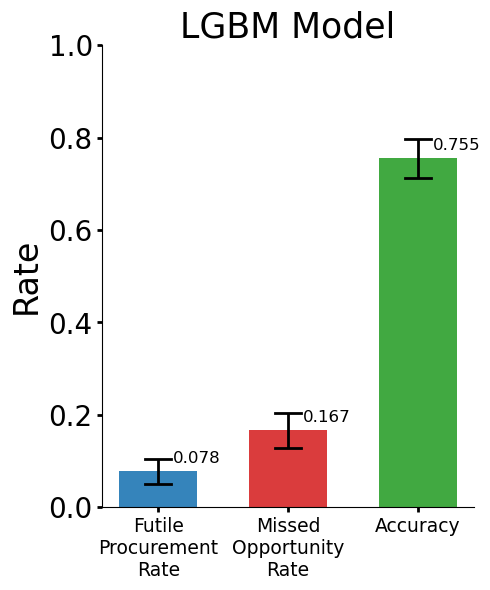

In [ ]:
def calculate_metrics_with_ci(df, pred_column, outcome_column):
    df_non_missing = df[df[pred_column].notna() & df[outcome_column].notna()]
    n = len(df_non_missing)  

    true_positive = ((df_non_missing[pred_column] == 1) & (df_non_missing[outcome_column] == 1)).sum()
    true_negative = ((df_non_missing[pred_column] == 0) & (df_non_missing[outcome_column] == 0)).sum()
    false_positive = ((df_non_missing[pred_column] == 1) & (df_non_missing[outcome_column] == 0)).sum()
    false_negative = ((df_non_missing[pred_column] == 0) & (df_non_missing[outcome_column] == 1)).sum()

    FPR = false_positive / n if n > 0 else 0
    FNR = false_negative / n if n > 0 else 0
    ACC = (true_positive + true_negative) / n if n > 0 else None
    
    # 95% CI
    def compute_ci(p, n):
        se = np.sqrt(p * (1 - p) / n)
        lower = max(0, p - 1.96 * se)
        upper = min(1, p + 1.96 * se)
        return lower, upper

    FPR_CI = compute_ci(FPR, n)
    FNR_CI = compute_ci(FNR, n)
    ACC_CI = compute_ci(ACC, n)
    
    return (FPR, FNR, ACC), (FPR_CI, FNR_CI, ACC_CI)

c = 'ML_predi2'
# c = 'DCD_Nscore2'
# c = 'Corolado'
['K_S', 'K_T', 'M_F', 'Y_B', 'J_K', 'D_S', 'Y_S','M_K','Jenny','Kliment','Melcher']
outcome_column = 'CSTATUS_30'
metrics, ci_values = calculate_metrics_with_ci(df, c, outcome_column)
FPR, FNR, ACC = metrics
FPR_CI, FNR_CI, ACC_CI = ci_values

metrics_names = ['Futile\nProcurement\nRate', 'Missed\nOpportunity\nRate', 'Accuracy']
values = [FPR, FNR, ACC]
ci_lower = [FPR_CI[0], FNR_CI[0], ACC_CI[0]]
ci_upper = [FPR_CI[1], FNR_CI[1], ACC_CI[1]]

colors = ['#1f77b4', '#d62728', '#2ca02c']

fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(metrics_names, values, color=colors, linewidth=2, alpha=0.9, width=0.6)

for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
    ax.plot([i - 0.1, i + 0.1], [lower, lower], color='black', linewidth=2)  
    ax.plot([i - 0.1, i + 0.1], [upper, upper], color='black', linewidth=2)  
    ax.vlines(i, lower, upper, color='black', linewidth=2)  

for i, value in enumerate(values):
    ax.text(i+0.3, value + 0.012, 
            f'{value:.3f}', 
            ha='center', va='bottom', fontsize=12, 
            rotation=0, 
            transform=ax.transData)

ax.tick_params(axis='both', which='major', labelsize=15, width=2)
ax.set_title('LGBM Model', fontsize=25)
ax.set_ylabel('Rate', fontsize=24)
ax.set_ylim(0, 1)  

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13.5)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()


Best Cutoff: 0.515


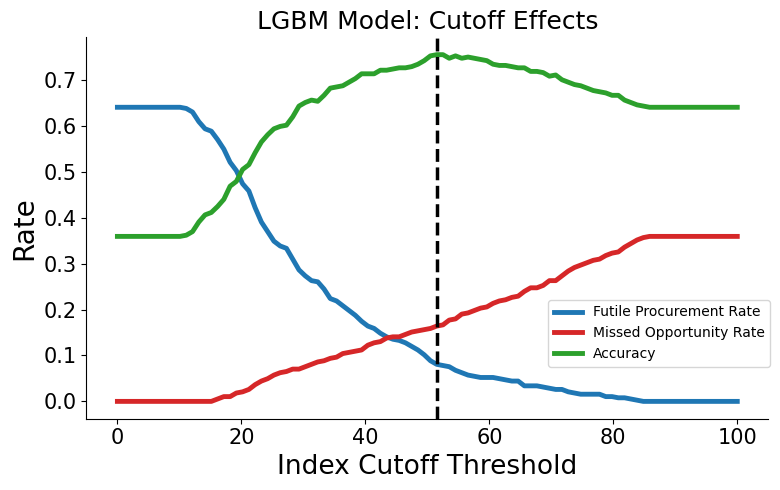

In [ ]:
def calculate_metrics_with_ci(df, pred_column, outcome_column, cutoff):
    df_non_missing = df[df[pred_column].notna() & df[outcome_column].notna()]
    n = len(df_non_missing) 

    y_pred_binary = (df_non_missing[pred_column] >= cutoff).astype(int)
    y_true = df_non_missing[outcome_column]

    FP = ((y_pred_binary == 1) & (y_true == 0)).sum()
    FN = ((y_pred_binary == 0) & (y_true == 1)).sum()
    TP = ((y_pred_binary == 1) & (y_true == 1)).sum()
    TN = ((y_pred_binary == 0) & (y_true == 0)).sum()

    FPR = FP / n if n > 0 else 0
    FNR = FN / n if n > 0 else 0
    ACC = (TP + TN) / n if n > 0 else None

    return FPR, FNR, ACC

cutoffs = np.linspace(0, 1, 100)  
outcome_column = 'CSTATUS_30'
prediction_column = 'ML_predi'

fpr_list, fnr_list, acc_list = [], [], []

for cutoff in cutoffs:
    FPR, FNR, ACC = calculate_metrics_with_ci(df, prediction_column, outcome_column, cutoff)
    fpr_list.append(FPR)
    fnr_list.append(FNR)
    acc_list.append(ACC)

youden_index = [1 - fpr - fnr for fpr, fnr in zip(fpr_list, fnr_list)]
optimal_idx = np.argmax(youden_index)  
optimal_cutoff = cutoffs[optimal_idx]  
print(f"Best Cutoff: {optimal_cutoff:.3f}")

plt.figure(figsize=(8, 5))

scaled_cutoffs = cutoffs * 100

plt.plot(scaled_cutoffs, fpr_list, label='Futile Procurement Rate', color='#1f77b4', linewidth=3.5)
plt.plot(scaled_cutoffs, fnr_list, label='Missed Opportunity Rate', color='#d62728', linewidth=3.5)
plt.plot(scaled_cutoffs, acc_list, label='Accuracy', color='#2ca02c', linewidth=3.5)

plt.axvline(optimal_cutoff * 100, color='black', linestyle='--', linewidth=2.5)

plt.xlabel('Index Cutoff Threshold', fontsize=19)
plt.ylabel('Rate', fontsize=20)
plt.title('LGBM Model: Cutoff Effects', fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.84, 0.33), fontsize=10)

ax = plt.gca()  
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
def calculate_metrics_with_ci(df, pred_column, outcome_column):
    df_non_missing = df[df[pred_column].notna() & df[outcome_column].notna()]
    n = len(df_non_missing)  
    
    true_positive = ((df_non_missing[pred_column] == 1) & (df_non_missing[outcome_column] == 1)).sum()
    true_negative = ((df_non_missing[pred_column] == 0) & (df_non_missing[outcome_column] == 0)).sum()
    false_positive = ((df_non_missing[pred_column] == 1) & (df_non_missing[outcome_column] == 0)).sum()
    false_negative = ((df_non_missing[pred_column] == 0) & (df_non_missing[outcome_column] == 1)).sum()
    
    FPR = false_positive / n if n > 0 else 0
    FNR = false_negative / n if n > 0 else 0
    ACC = (true_positive + true_negative) / n if n > 0 else None

    def compute_ci(p, n):
        se = np.sqrt(p * (1 - p) / n)
        lower = max(0, p - 1.96 * se)
        upper = min(1, p + 1.96 * se)
        return lower, upper

    return (FPR, FNR, ACC), (compute_ci(FPR, n), compute_ci(FNR, n), compute_ci(ACC, n))

columns = [
           'K_S', 
           'K_T',
           'Melcher', 
           'J_K',
           'M_F', 
           'Y_B',  
           'D_S', 
           'Y_S', 
           'M_K', 
           'Jenny', 
           'Kliment', 
           ]
outcome_column = 'CSTATUS_30'
FPRs, FNRs, ACCs = [], [], []
FPR_CI, FNR_CI, ACC_CI = [], [], []

for col in columns:
    metrics, ci = calculate_metrics_with_ci(df, col, outcome_column)
    FPRs.append(metrics[0])
    FNRs.append(metrics[1])
    ACCs.append(metrics[2])
    FPR_CI.append(ci[0])
    FNR_CI.append(ci[1])
    ACC_CI.append(ci[2])

avg_FPR, avg_FNR, avg_ACC = np.mean(FPRs), np.mean(FNRs), np.mean(ACCs)
avg_FPR_CI = (np.mean([ci[0] for ci in FPR_CI]), np.mean([ci[1] for ci in FPR_CI]))
avg_FNR_CI = (np.mean([ci[0] for ci in FNR_CI]), np.mean([ci[1] for ci in FNR_CI]))
avg_ACC_CI = (np.mean([ci[0] for ci in ACC_CI]), np.mean([ci[1] for ci in ACC_CI]))

metrics_names = ['Futile\nProcurement\nRate', 'Missed\nOpportunity\nRate', 'Accuracy']
values = [avg_FPR, avg_FNR, avg_ACC]
ci_lower = [avg_FPR_CI[0], avg_FNR_CI[0], avg_ACC_CI[0]]
ci_upper = [avg_FPR_CI[1], avg_FNR_CI[1], avg_ACC_CI[1]]
colors = ['#1f77b4', '#d62728', '#2ca02c'] 

fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(metrics_names, values, color=colors, linewidth=2, alpha=0.9, width=0.6)

for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
    ax.vlines(i, lower, upper, color='black', linewidth=2) 
    ax.plot([i - 0.1, i + 0.1], [lower, lower], color='black', linewidth=2)  
    ax.plot([i - 0.1, i + 0.1], [upper, upper], color='black', linewidth=2)  

for i, value in enumerate(values):
    ax.text(i+0.3, value + 0.012, 
            f'{value:.3f}', 
            ha='center', va='bottom', fontsize=12, 
            rotation=0,  
            transform=ax.transData)

ax.tick_params(axis='both', which='major', labelsize=15, width=2)
ax.set_title('Humans Average', fontsize=22)#Worst 3 
ax.set_ylabel('Rate', fontsize=20)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13.5)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


In [ ]:
probabilities = np.array(df['ML_predi'].tolist())
model_predictions = (probabilities >= 0.52).astype(int)
probabilities = np.array(df['Human'].tolist())
human_predictions = (probabilities >= 0.5).astype(int)
KS_predictions = df['K_S'].tolist()
KT_predictions = df['K_T'].tolist()
MF_predictions = df['M_F'].tolist()
YB_predictions = df['Y_B'].tolist()
JK_predictions = df['J_K'].tolist()
DS_predictions = df['D_S'].tolist()
YS_predictions = df['Y_S'].tolist()
MK_predictions = df['M_K'].tolist()
Jenny_predictions = df['Jenny'].tolist()
Kliment_predictions = df['Kliment'].tolist()
Melcher_predictions = df['Melcher'].tolist()
DCDNScore_predictions = df['DCD_Nscore2'].tolist()
Corolado_predictions = df['Corolado'].tolist()
actual_outcomes = df['CSTATUS_30'].tolist()

data = pd.DataFrame({
    'Probability': probabilities,
    'KS_Prediction': KS_predictions,
    'Model_Prediction': model_predictions,
    'Human_Prediction': human_predictions,
    'KT_Prediction': KT_predictions,
    'MF_Prediction': MF_predictions,
    'YB_Prediction': YB_predictions,
    'JK_Prediction': JK_predictions,
    'DS_Prediction': DS_predictions,
    'YS_Prediction': YS_predictions,
    'MK_Prediction': MK_predictions,
    'Jenny_Prediction': Jenny_predictions,
    'Kliment_Prediction': Kliment_predictions,
    'Melcher_Prediction': Melcher_predictions,
    'DCDNScore_Prediction': DCDNScore_predictions,
    'Corolado_Prediction': Corolado_predictions,
    'Actual_Outcome': actual_outcomes
})

# Custom bins: 0/n, 1/n, ..., n/n
n = 12
bins = [i/n for i in range(n+1)]
labels = [f"{bins[i]}~{bins[i+1]}" for i in range(len(bins)-1)]
data['Probability_Bin'] = pd.cut(data['Probability'], bins=bins, labels=labels, include_lowest=True)

grouped_bins = {
    'Strong Agreement': [labels[0], labels[11],labels[1], labels[10]],
    'General Agreement': [labels[2], labels[9]],
    'Weak Agreement': [labels[3], labels[8]],
    'Poor Agreement': [labels[4],labels[7],labels[5],labels[6]],
}

def calculate_group_accuracy(group):
    subset = data[data['Probability_Bin'].isin(group)]
    accuracy = {}
    accuracy['KS'] = (subset['KS_Prediction'] == subset['Actual_Outcome']).sum() / subset['KS_Prediction'].notna().sum()
    accuracy['Model'] = (subset['Model_Prediction'] == subset['Actual_Outcome']).sum() / subset['Model_Prediction'].notna().sum()
    accuracy['Human'] = (subset['Human_Prediction'] == subset['Actual_Outcome']).sum() / subset['Model_Prediction'].notna().sum()
    accuracy['KT'] = (subset['KT_Prediction'] == subset['Actual_Outcome']).sum() / subset['KT_Prediction'].notna().sum()
    accuracy['MF'] = (subset['MF_Prediction'] == subset['Actual_Outcome']).sum() / subset['MF_Prediction'].notna().sum()
    accuracy['YB'] = (subset['YB_Prediction'] == subset['Actual_Outcome']).sum() / subset['YB_Prediction'].notna().sum()
    accuracy['JK'] = (subset['JK_Prediction'] == subset['Actual_Outcome']).sum() / subset['JK_Prediction'].notna().sum()
    accuracy['DS'] = (subset['DS_Prediction'] == subset['Actual_Outcome']).sum() / subset['DS_Prediction'].notna().sum()
    accuracy['YS'] = (subset['YS_Prediction'] == subset['Actual_Outcome']).sum() / subset['YS_Prediction'].notna().sum()
    accuracy['MK'] = (subset['MK_Prediction'] == subset['Actual_Outcome']).sum() / subset['MK_Prediction'].notna().sum()
    accuracy['Jenny'] = (subset['Jenny_Prediction'] == subset['Actual_Outcome']).sum() / subset['Jenny_Prediction'].notna().sum()
    accuracy['Kliment'] = (subset['Kliment_Prediction'] == subset['Actual_Outcome']).sum() / subset['Kliment_Prediction'].notna().sum()
    accuracy['Melcher'] = (subset['Melcher_Prediction'] == subset['Actual_Outcome']).sum() / subset['Melcher_Prediction'].notna().sum()
    accuracy['DCDNScore'] = (subset['DCDNScore_Prediction'] == subset['Actual_Outcome']).sum() / subset['DCDNScore_Prediction'].notna().sum()
    accuracy['Corolado'] = (subset['Corolado_Prediction'] == subset['Actual_Outcome']).sum() / subset['Corolado_Prediction'].notna().sum()
    return pd.Series(accuracy)

accuracy_df = pd.DataFrame({k: calculate_group_accuracy(v) for k, v in grouped_bins.items()}).T
accuracy_df['Human Average'] = accuracy_df[['KS', 'KT', 'MF', 'YB', 'JK', 'DS','YS','MK','Jenny','Kliment','Melcher']].mean(axis=1)

fig, ax = plt.subplots(figsize=(9.5, 12))
accuracy_df['KS'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['KT'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['MF'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['YB'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['JK'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='Individual Surgeon')
accuracy_df['DS'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['YS'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['MK'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['Jenny'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['Kliment'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['Melcher'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['DCDNScore'].plot(kind='line', ax=ax, marker='o', color='#2ca02c', markersize=10, linestyle='-', linewidth=4, label='DCD-N score Prediction')
accuracy_df['Corolado'].plot(kind='line', ax=ax, marker='o', color='#1a5d8f', markersize=10, linestyle='-', linewidth=4, label='Colorado Prediction')
accuracy_df['Model'].plot(kind='line', ax=ax, marker='o', color='#d62728', markersize=10, linestyle='-', linewidth=4, label='LGBM Model')
# accuracy_df['Human'].plot(kind='line', ax=ax, marker='o', color='black', markersize=10, linestyle='-', linewidth=4, label='Human Majority Decision Accuracy')
accuracy_df['Human Average'].plot(kind='line', ax=ax, marker='o', color='black', markersize=10, linestyle='-', linewidth=4, label='Human Average Accuracy')

# Define custom offsets for label placement to avoid overlap
def adjust_text_position(index, value, line_type):
    # Adjust specific overlapping points with more granular control
    if index == 0:  # First point
        if line_type == 'Model':  # Red line
            return 0.02  # Move label up
        elif line_type == 'DCDNScore':  # Blue line
            return -0.024 # Move label down
    if index == 1:  # Second point
        if line_type == 'Model':
            return -0.02
        elif line_type == 'DCDNScore':
            return 0.015
        elif line_type == 'Corolado':
            return -0.02
    if index == 2:  # Second point
        if line_type == 'Human Average':
            return -0.02
        elif line_type == 'Corolado':
            return 0.012
        elif line_type == 'DCDNScore':
            return -0.02
    if index == 3:  # Second point
        if line_type == 'DCDNScore':
            return -0.02
    # Default adjustment for non-overlapping points
    return 0.01

# Plot and add labels with adjusted positions
for i, value in enumerate(accuracy_df['Human Average']):
    ax.text(i, value + adjust_text_position(i, value, 'Human Average'), f'{value:.2f}', 
            ha='center', fontsize=13, color='black')
for i, value in enumerate(accuracy_df['Corolado']):
    ax.text(i, value + adjust_text_position(i, value, 'Corolado'), f'{value:.2f}', 
            ha='center', fontsize=13, color='#1a5d8f')
for i, value in enumerate(accuracy_df['DCDNScore']):
    ax.text(i, value + adjust_text_position(i, value, 'DCDNScore'), f'{value:.2f}', 
            ha='center', fontsize=13, color='#2ca02c')
for i, value in enumerate(accuracy_df['Model']):
    ax.text(i, value + adjust_text_position(i, value, 'Model'), f'{value:.2f}', 
            ha='center', fontsize=13, color='#d62728')

ax.set_title('Accuracy (30min)',  fontsize=27)
ax.set_xlabel('Human Confidence Level',  fontsize=24)
ax.set_ylabel('Accuracy',  fontsize=24)
ax.set_yticks(np.arange(0.3, 1.1, 0.1))
ax.legend(fontsize=18)
ax.tick_params(axis='both', labelsize=22)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(rotation=45, fontsize=19)
plt.show()




In [ ]:
probabilities = np.array(df['ML_predi'].tolist())
model_predictions = (probabilities >= 0.52).astype(int)
probabilities = np.array(df['Human'].tolist())
human_predictions = (probabilities >= 0.5).astype(int)
KS_predictions = df['K_S'].tolist()
KT_predictions = df['K_T'].tolist()
MF_predictions = df['M_F'].tolist()
YB_predictions = df['Y_B'].tolist()
JK_predictions = df['J_K'].tolist()
DS_predictions = df['D_S'].tolist()
YS_predictions = df['Y_S'].tolist()
MK_predictions = df['M_K'].tolist()
Jenny_predictions = df['Jenny'].tolist()
Kliment_predictions = df['Kliment'].tolist()
Melcher_predictions = df['Melcher'].tolist()
DCDNScore_predictions = df['DCD_Nscore2'].tolist()
Corolado_predictions = df['Corolado'].tolist()
actual_outcomes = df['CSTATUS_45'].tolist()

data = pd.DataFrame({
    'Probability': probabilities,
    'KS_Prediction': KS_predictions,
    'Model_Prediction': model_predictions,
    'Human_Prediction': human_predictions,
    'KT_Prediction': KT_predictions,
    'MF_Prediction': MF_predictions,
    'YB_Prediction': YB_predictions,
    'JK_Prediction': JK_predictions,
    'DS_Prediction': DS_predictions,
    'YS_Prediction': YS_predictions,
    'MK_Prediction': MK_predictions,
    'Jenny_Prediction': Jenny_predictions,
    'Kliment_Prediction': Kliment_predictions,
    'Melcher_Prediction': Melcher_predictions,
    'DCDNScore_Prediction': DCDNScore_predictions,
    'Corolado_Prediction': Corolado_predictions,
    'Actual_Outcome': actual_outcomes
})

# Custom bins: 0/n, 1/n, ..., n/n
n = 12
bins = [i/n for i in range(n+1)]
labels = [f"{bins[i]}~{bins[i+1]}" for i in range(len(bins)-1)]
data['Probability_Bin'] = pd.cut(data['Probability'], bins=bins, labels=labels, include_lowest=True)

grouped_bins = {
    'Strong Agreement': [labels[0], labels[11],labels[1], labels[10]],
    'General Agreement': [labels[2], labels[9]],
    'Weak Agreement': [labels[3], labels[8]],
    'Poor Agreement': [labels[4],labels[7],labels[5],labels[6]],
}

def calculate_group_accuracy(group):
    subset = data[data['Probability_Bin'].isin(group)]
    accuracy = {}
    accuracy['KS'] = (subset['KS_Prediction'] == subset['Actual_Outcome']).sum() / subset['KS_Prediction'].notna().sum()
    accuracy['Model'] = (subset['Model_Prediction'] == subset['Actual_Outcome']).sum() / subset['Model_Prediction'].notna().sum()
    accuracy['Human'] = (subset['Human_Prediction'] == subset['Actual_Outcome']).sum() / subset['Model_Prediction'].notna().sum()
    accuracy['KT'] = (subset['KT_Prediction'] == subset['Actual_Outcome']).sum() / subset['KT_Prediction'].notna().sum()
    accuracy['MF'] = (subset['MF_Prediction'] == subset['Actual_Outcome']).sum() / subset['MF_Prediction'].notna().sum()
    accuracy['YB'] = (subset['YB_Prediction'] == subset['Actual_Outcome']).sum() / subset['YB_Prediction'].notna().sum()
    accuracy['JK'] = (subset['JK_Prediction'] == subset['Actual_Outcome']).sum() / subset['JK_Prediction'].notna().sum()
    accuracy['DS'] = (subset['DS_Prediction'] == subset['Actual_Outcome']).sum() / subset['DS_Prediction'].notna().sum()
    accuracy['YS'] = (subset['YS_Prediction'] == subset['Actual_Outcome']).sum() / subset['YS_Prediction'].notna().sum()
    accuracy['MK'] = (subset['MK_Prediction'] == subset['Actual_Outcome']).sum() / subset['MK_Prediction'].notna().sum()
    accuracy['Jenny'] = (subset['Jenny_Prediction'] == subset['Actual_Outcome']).sum() / subset['Jenny_Prediction'].notna().sum()
    accuracy['Kliment'] = (subset['Kliment_Prediction'] == subset['Actual_Outcome']).sum() / subset['Kliment_Prediction'].notna().sum()
    accuracy['Melcher'] = (subset['Melcher_Prediction'] == subset['Actual_Outcome']).sum() / subset['Melcher_Prediction'].notna().sum()
    accuracy['DCDNScore'] = (subset['DCDNScore_Prediction'] == subset['Actual_Outcome']).sum() / subset['DCDNScore_Prediction'].notna().sum()
    accuracy['Corolado'] = (subset['Corolado_Prediction'] == subset['Actual_Outcome']).sum() / subset['Corolado_Prediction'].notna().sum()
    return pd.Series(accuracy)

accuracy_df = pd.DataFrame({k: calculate_group_accuracy(v) for k, v in grouped_bins.items()}).T
accuracy_df['Human Average'] = accuracy_df[['KS', 'KT', 'MF', 'YB', 'JK', 'DS','YS','MK','Jenny','Kliment','Melcher']].mean(axis=1)

fig, ax = plt.subplots(figsize=(9.5, 12))
accuracy_df['KS'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['KT'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['MF'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['YB'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['JK'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='Each Surgeon')
accuracy_df['DS'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['YS'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['MK'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['Jenny'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['Kliment'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['Melcher'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
accuracy_df['DCDNScore'].plot(kind='line', ax=ax, marker='o', color='#2ca02c', markersize=10, linestyle='-', linewidth=4, label='DCD-N score Prediction')
accuracy_df['Corolado'].plot(kind='line', ax=ax, marker='o', color='#1a5d8f', markersize=10, linestyle='-', linewidth=4, label='Colorado Prediction')
accuracy_df['Model'].plot(kind='line', ax=ax, marker='o', color='#d62728', markersize=10, linestyle='-', linewidth=4, label='LGBM Calculator')
# accuracy_df['Human'].plot(kind='line', ax=ax, marker='o', color='black', markersize=10, linestyle='-', linewidth=4, label='Human Majority Decision Accuracy')
accuracy_df['Human Average'].plot(kind='line', ax=ax, marker='o', color='black', markersize=10, linestyle='-', linewidth=4, label='Human Average Accuracy')

# Define custom offsets for label placement to avoid overlap
def adjust_text_position(index, value, line_type):
    # Adjust specific overlapping points with more granular control
    if index == 0:  # First point
        if line_type == 'Model':  # Red line
            return 0.018  # Move label up
        elif line_type == 'DCDNScore':  # Blue line
            return -0.02 # Move label down
        elif line_type == 'Human Average':
            return -0.02
    if index == 1:  # Second point
        if line_type == 'Model':
            return -0.02
        elif line_type == 'DCDNScore':
            return 0.015
        elif line_type == 'Corolado':
            return 0.016
        elif line_type == 'Human Average':
            return -0.02
    if index == 2:  # Second point
        if line_type == 'Human Average':
            return -0.02
        elif line_type == 'Corolado':
            return -0.025
        elif line_type == 'DCDNScore':
            return 0.009
    if index == 3:  # Second point
        if line_type == 'DCDNScore':
            return -0.018
        elif line_type == 'Human Average':
            return -0.02
        elif line_type == 'Corolado':
            return -0.02
    # Default adjustment for non-overlapping points
    return 0.01

# Plot and add labels with adjusted positions
for i, value in enumerate(accuracy_df['Human Average']):
    ax.text(i, value + adjust_text_position(i, value, 'Human Average'), f'{value:.2f}', 
            ha='center', fontsize=13, color='black')
for i, value in enumerate(accuracy_df['Corolado']):
    ax.text(i, value + adjust_text_position(i, value, 'Corolado'), f'{value:.2f}', 
            ha='center', fontsize=13, color='#1a5d8f')
for i, value in enumerate(accuracy_df['DCDNScore']):
    ax.text(i, value + adjust_text_position(i, value, 'DCDNScore'), f'{value:.2f}', 
            ha='center', fontsize=13, color='#2ca02c')
for i, value in enumerate(accuracy_df['Model']):
    ax.text(i, value + adjust_text_position(i, value, 'Model'), f'{value:.2f}', 
            ha='center', fontsize=13, color='#d62728')

ax.set_title('Accuracy (45min)',  fontsize=27)
ax.set_xlabel('Human Confidence Level',  fontsize=24)
ax.set_ylabel('Accuracy',  fontsize=24)
ax.set_yticks(np.arange(0.3, 1.1, 0.1))
# ax.legend(fontsize=18)
ax.tick_params(axis='both', labelsize=22)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(rotation=45, fontsize=19)
plt.show()


In [ ]:
probabilities = np.array(df['ML_predi'].tolist())
model_predictions = (probabilities >= 0.52).astype(int)
probabilities = np.array(df['Human'].tolist())
human_predictions = (probabilities >= 0.5).astype(int)
KS_predictions = df['K_S'].tolist()
KT_predictions = df['K_T'].tolist()
MF_predictions = df['M_F'].tolist()
YB_predictions = df['Y_B'].tolist()
JK_predictions = df['J_K'].tolist()
DS_predictions = df['D_S'].tolist()
YS_predictions = df['Y_S'].tolist()
MK_predictions = df['M_K'].tolist()
Jenny_predictions = df['Jenny'].tolist()
Kliment_predictions = df['Kliment'].tolist()
Melcher_predictions = df['Melcher'].tolist()
DCDNScore_predictions = df['DCD_Nscore2'].tolist()
Corolado_predictions = df['Corolado'].tolist()
actual_outcomes = df['CSTATUS_30'].tolist()

data = pd.DataFrame({
    'Probability': probabilities,
    'KS_Prediction': KS_predictions,
    'Model_Prediction': model_predictions,
    'Human_Prediction': human_predictions,
    'KT_Prediction': KT_predictions,
    'MF_Prediction': MF_predictions,
    'YB_Prediction': YB_predictions,
    'JK_Prediction': JK_predictions,
    'DS_Prediction': DS_predictions,
    'YS_Prediction': YS_predictions,
    'MK_Prediction': MK_predictions,
    'Jenny_Prediction': Jenny_predictions,
    'Kliment_Prediction': Kliment_predictions,
    'Melcher_Prediction': Melcher_predictions,
    'DCDNScore_Prediction': DCDNScore_predictions,
    'Corolado_Prediction': Corolado_predictions,
    'Actual_Outcome': actual_outcomes
})

# Custom bins: 0/n, 1/n, ..., n/n
n = 12
bins = [i/n for i in range(n+1)]
labels = [f"{bins[i]}~{bins[i+1]}" for i in range(len(bins)-1)]
data['Probability_Bin'] = pd.cut(data['Probability'], bins=bins, labels=labels, include_lowest=True)

grouped_bins = {
    'Strong Agreement': [labels[0], labels[11],labels[1], labels[10]],
    'General Agreement': [labels[2], labels[9]],
    'Weak Agreement': [labels[3], labels[8]],
    'Poor Agreement': [labels[4],labels[7],labels[5],labels[6]],
}

def calculate_group_false_positive_rate(group):
    subset = data[data['Probability_Bin'].isin(group)]
    false_positive_rate = {}
    
    for col in ['KS_Prediction', 'Model_Prediction', 'Human_Prediction', 'KT_Prediction', 'MF_Prediction',
                'YB_Prediction', 'JK_Prediction', 'DS_Prediction', 'YS_Prediction', 'MK_Prediction',
                'Jenny_Prediction', 'Kliment_Prediction', 'Melcher_Prediction', 'DCDNScore_Prediction', 'Corolado_Prediction']:
        
        total_actual_0 = len(subset['Actual_Outcome'])
        false_positive = ((subset['Actual_Outcome'] == 0) & (subset[col] == 1)).sum()
        false_positive_rate[col] = false_positive / total_actual_0 if total_actual_0 > 0 else np.nan  # 分母が0の場合はNaNを返す
    
    return pd.Series(false_positive_rate)

false_positive_df = pd.DataFrame({k: calculate_group_false_positive_rate(v) for k, v in grouped_bins.items()}).T
false_positive_df['Human Average'] = false_positive_df[['KS_Prediction', 'KT_Prediction', 'MF_Prediction', 'YB_Prediction', 
                                                        'JK_Prediction', 'DS_Prediction', 'YS_Prediction', 'MK_Prediction', 
                                                        'Jenny_Prediction', 'Kliment_Prediction', 'Melcher_Prediction']].mean(axis=1)

fig, ax = plt.subplots(figsize=(9, 12))
false_positive_df['KS_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['KT_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['MF_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['YB_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['JK_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='Each Surgeon')
false_positive_df['DS_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['YS_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['MK_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['Jenny_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['Kliment_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['Melcher_Prediction'].plot(kind='line', ax=ax, marker='o', color=(0, 0, 0, 0.25), markersize=10, linestyle='-', linewidth=4, label='')
false_positive_df['DCDNScore_Prediction'].plot(kind='line', ax=ax, marker='o', color='#2ca02c', markersize=10, linestyle='-', linewidth=4, label='DCD-N score Prediction')
false_positive_df['Corolado_Prediction'].plot(kind='line', ax=ax, marker='o', color='#1a5d8f', markersize=10, linestyle='-', linewidth=4, label='Colorado Prediction')
false_positive_df['Model_Prediction'].plot(kind='line', ax=ax, marker='o', color='#d62728', markersize=10, linestyle='-', linewidth=4, label='LGBM Calculator')
false_positive_df['Human Average'].plot(kind='line', ax=ax, marker='o', color='black', markersize=10, linestyle='-', linewidth=4, label='Human Average False Positive Rate')

ax.set_title('Futile Procurement (45min)', fontsize=27)
ax.set_xlabel('Human Confidence Level', fontsize=24)
ax.set_ylabel('Futile Procurement Rate', fontsize=24)
ax.set_yticks(np.arange(0, 0.6, 0.1))
ax.tick_params(axis='both', labelsize=22)
for spine in ax.spines.values():
    spine.set_linewidth(2)


def adjust_text_position(index, value, line_type):
    if index == 0:
        if line_type == 'Model_Prediction':
            return -0.024
        elif line_type == 'DCDNScore_Prediction':
            return 0.01
        elif line_type == 'Human Average':
            return 0.012
    if index == 1:
        if line_type == 'Model_Prediction':
            return -0.02
        elif line_type == 'DCDNScore_Prediction':
            return 0.01
        elif line_type == 'Corolado_Prediction':
            return 0.011
        elif line_type == 'Human Average':
            return 0.01
    if index == 2:
        if line_type == 'Human Average':
            return 0.01
        elif line_type == 'Corolado_Prediction':
            return -0.02
        elif line_type == 'DCDNScore_Prediction':
            return -0.02
    if index == 3:
        if line_type == 'DCDNScore_Prediction':
            return 0.01
        elif line_type == 'Model_Prediction':
            return -0.02
        elif line_type == 'Corolado_Prediction':
            return -0.02
    return 0.01

for i, value in enumerate(false_positive_df['Human Average']):
    if not np.isnan(value):  
        ax.text(i, value + adjust_text_position(i, value, 'Human Average'), f'{value:.2f}', 
                ha='center', fontsize=13, color='black')

for i, value in enumerate(false_positive_df['Corolado_Prediction']):
    if not np.isnan(value):
        ax.text(i, value + adjust_text_position(i, value, 'Corolado_Prediction'), f'{value:.2f}', 
                ha='center', fontsize=13, color='#1a5d8f')

for i, value in enumerate(false_positive_df['DCDNScore_Prediction']):
    if not np.isnan(value):
        ax.text(i, value + adjust_text_position(i, value, 'DCDNScore_Prediction'), f'{value:.2f}', 
                ha='center', fontsize=13, color='#2ca02c')

for i, value in enumerate(false_positive_df['Model_Prediction']):
    if not np.isnan(value):
        ax.text(i, value + adjust_text_position(i, value, 'Model_Prediction'), f'{value:.2f}', 
                ha='center', fontsize=13, color='#d62728')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(rotation=45, fontsize=19)
plt.show()
